In [12]:
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page

from Pylice_def.shift_scheduling import preprocess as sched_prep
from Pylice_def.shift_scheduling.optimization import pylice_opt_model_hard, optimize_hard
from Pylice_def.shift_scheduling import page as shift_page
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import datetime as dt
def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):
    allowed_lens = set(list(map(int, allowed_lens)))
    ts = sched_prep.horizon_timestamps(n_weeks,f)
    possible_shifts, starts_ends = sched_prep.create_possible_shifs(ts, sched_prep.create_forbidden_shifts(earliest_shift,latest_shift, f),allowed_lens, f)
    shifts_info = sched_prep.compute_shift_statistics(possible_shifts, f)
    shifts_info["Start_end"] = starts_ends
    possible_shifts = sched_prep.change_column_names(possible_shifts,ts,f)
    min_demand = sched_prep.create_min_demand(ts, minimum_night, minimum_day, f)
    shift_costs = shifts_info["cost"].copy(deep = True)
    shift_costs = shift_costs.to_dict()
    S = possible_shifts.index.tolist()
    ts = possible_shifts.columns.tolist()
    demand.index = ts
    min_demand.index = ts
    demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
    shift_day_match_start, shift_day_match_end = sched_prep.match_starting_ending(ts, shifts_info)
    day_shift_match = sched_prep.create_coverage(possible_shifts)
    return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info


def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
    choosen = []
    for i in model.ShiftSelect:
        choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
    choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
    # print(choosen)
    choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
    choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
    new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] +1 , choosen.index.tolist()))
    for n, i in enumerate(new_end):
        if i == len(ts_horizon):
            new_end[n] = 0
    choosen["end_num"] = new_end
    choosen["start"] = choosen["start_num"].apply(lambda x: shift_page.from_num_to_date(x, f))
    choosen["end"] = choosen["end_num"].apply(lambda x :shift_page.from_num_to_date(x, f))
    choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
    choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
    choosen.sort_values("start_num", inplace = True)
    target = dt.timedelta(minutes = overlap)
    max_allowed_len = max(shift_lenghts)
    ##
    # shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
    shifts = list(map(list, choosen.reset_index().to_numpy()))
    shifts = pd.DataFrame(shifts)
    ##
    shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
    shifts.drop("len", axis = 1, inplace = True)
    shifts.set_index("Shift_name", inplace = True)
    shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

    layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
    for ind in layover:
        shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
                                    shifts.loc[ind, "start_num"],\
                                    0,\
                                    shifts.loc[ind, "start"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "start-end"]
        
        shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
                                    0,\
                                    shifts.loc[ind, "end_num"],\
                                    pd.to_datetime("2023-01-01 00:00:00"),\
                                    shifts.loc[ind, "end"],\
                                    shifts.loc[ind, "start-end"]
        shifts.drop(ind, inplace = True)

    shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
    coverage = shifts[["staff", "start", "end"]].copy()
    ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
    shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
    shifts.drop(["start", "end"], axis = 1, inplace = True)
    layover = shifts.loc[shifts["len"] < 0].index.tolist()
    for i in layover:
        shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
    shifts['color'] = shifts.apply(lambda df: shift_page.color(df), axis=1)
    shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
    shifts.sort_values("start-end", inplace = True, ascending= False)
    print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
    shifts["end_num"] = shifts["start_num"] + shifts["len"] 
    return shifts, coverage

def plot_staffing_requirements(demand, params,t):
        q = 60//t
        demand["how"] = demand.reset_index(inplace = False).index
        axs = plt.subplot()
        y_max = demand.Staffing_level.max() +2 
        y_min = max(0, demand.Staffing_level.min() -2) 
        plt.plot(demand["how"], demand["Staffing_level"],zorder = 2, color = "green")
        for day in range(0,(24*7*q), 24*q):
                axs.vlines(x = day, ymin = 0, ymax =y_max + 0.2, color = "blue", zorder = 1, alpha = .4, linestyles= "dashed")
        # axs.hlines(y = 3, xmin=demand["how"].min(), xmax = demand["how"].max(), color = "tomato", zorder = 2)
        axs.set_xticks(list(range(1,(24*7*q)+1, 24*q)))
        xticks_minor = list(range(0 ,(24*7*q)+1,q))
        axs.set_xticks(xticks_minor, minor=True)
        axs.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
        axs.set_xlim(xmin= 0, xmax = 24*7*q)
        axs.set_ylim(ymin= 1, ymax = y_max -1)
        axs.set_facecolor("lightgray")
        axs.set_ylabel("Number of employees")
        axs.set_xlabel("Average Week")
        plt.show()
        print("Call Type:", call_type)
        for p in params.keys():
                text = f"{p.title()}: {params[p][call_type]}"
                if p in {"asa", "aht"}:
                        text += " seconds"
                elif p in {"max_occupancy", "shrinkage", "service_level"}:
                        text += "%"
                print(text)
timeframe = 30
horizon = 9
all_data = []
for file in os.listdir("..\data\List_Raw\\112_Soer_Oest"):
    file = "..\\data\\List_Raw\\112_Soer_Oest\\" + file
    all_data.append(data_page.import_file(file))


call_types = ["112","02800"]
### Prepare
a, all_data, b, c = prep.prepare_data(all_data, timeframe)
for n in range(len(all_data)):
    data = all_data[n]
    call_type = call_types[n]
    ### Forecast
    x_train, y_train, x_test, y_test = modelling.custom_train_test_split(data.copy(deep = True), s_start= pd.to_datetime("2023-01-07 00:00:00"), horizon = 9)
    model = modelling.xgb_model()
    model.fit(x_train, y_train)
    print(modelling.mae(y_train,np.round(model.predict(x_train).flatten())))
    print(modelling.mae(y_test,np.round(model.predict(x_test).flatten())))
    X_train = data.copy(deep = True)
    Y_train = X_train.pop("Calls")
    model.fit(X_train, Y_train)
    print(modelling.mae(Y_train,np.round(model.predict(X_train).flatten())))

    from_date = pd.to_datetime("2023-01-07 00:00:00")
    future_dates = forecasts.create_horizon_dates(from_date, horizon, timeframe)
    future_data = forecasts.create_horizon_data(future_dates)
    predictions = model.predict(future_data)
    predictions = forecasts.create_prediction_output(future_dates, predictions, call_type)

    # DEFAULT NO WRAP UP -OK 
    # params = {"service_level" : {"112" : 90, "02800" : 80},
    #           "shrinkage" : {"112" : 30, "02800" : 30},
    #           "max_occupancy" : {"112" : 80, "02800" : 80}, #85
    #           "asa" : {"112" : 20, "02800" : 180},
    #           "aht": {"112" : 120, "02800" : 200}} #120 , 180

    # # DEFAULT SCENARIO PARAMETERS - OK 
    # params = {"service_level" : {"112" : 90, "02800" : 80},
    #         "shrinkage" :     {"112" : 30, "02800" : 30},
    #         "max_occupancy" : {"112" : 80, "02800" : 80},
    #         "asa" :           {"112" : 20, "02800" : 180},
    #         "aht":            {"112" : 320,"02800" : 380}}

    # PUBLIC EVENTS SCENARIO PARAMETERS - OK 
    # params = {"service_level" : {"112" : 95, "02800" : 80},
    #         "shrinkage" :     {"112" : 25, "02800" : 25},
    #         "max_occupancy" : {"112" : 80, "02800" : 75},
    #         "asa" :           {"112" : 15, "02800" : 200},
    #         "aht":            {"112" : 350,"02800" : 380}}

    # HOLIDAYS EVENTS SCENARIO PARAMETERS - OK 
    params = {"service_level" : {"112" : 90, "02800" : 80},
            "shrinkage" :     {"112" : 35, "02800" : 35},
            "max_occupancy" : {"112" : 75, "02800" : 75},
            "asa" :           {"112" : 15, "02800" : 180},
            "aht":            {"112" : 280,"02800" : 340}}

    service_level = value= params["service_level"][call_type]
    asa = value = params["asa"][call_type]
    aht = params["aht"][call_type]
    shrinkage = params["shrinkage"][call_type]
    max_occupancy = params["max_occupancy"][call_type]
    aht  = [int(aht//60)]
    asa  = [asa/60]
    shrinkage  = [shrinkage/100]
    service_level  = [service_level/100]
    max_occupancy  = [max_occupancy/100]
    final_staffing_levels = dict()
    sub = predictions.copy(deep = True)
    sub = q_page.prepare_CyclicWeek(sub, Type = call_type)
    staffing_levels = sim.compute_staffing_levels(  demand = sub,
                                                    aht = aht,
                                                    planning_period = [timeframe],
                                                    asa = asa,
                                                    shrinkage = shrinkage,
                                                    service_level = service_level,
                                                    max_occupancy = max_occupancy,
                                                    Type = call_type)


    if n == 0:
        demand_112 = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)
    else:
        demand_02  = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)


demand = demand_112 + demand_02
demand["112"] = demand_112["Staffing_level"]
demand["02800"] = demand_02["Staffing_level"]
# plot_staffing_requirements(demand, params,timeframe)


two types
2.25
2.15
2.15
1.32
1.27
1.32


In [2]:
# ax = demand["Staffing_level"].plot(label = "02800 calls + 112 calls")
# ax1 = demand["02800"].plot(label = "02800 calls")
# ax1.set_xticklabels(["","Monday 06:00:00", "Tuesday 06:00:00", "Wednesday 06:00:00", "Thursday 06:00:00", "Friday 06:00:00", "Saturday 06:00:00", "Sunday 06:00:00", "", ""], rotation = 45)
# ax.set_xticklabels(["","Monday 06:00:00", "Tuesday 06:00:00", "Wednesday 06:00:00", "Thursday 06:00:00", "Friday 06:00:00", "Saturday 06:00:00", "Sunday 06:00:00", "", ""], rotation = 45)

# # plt.tick_params(rotation = 45)
# plt.legend()
# plt.show()

In [13]:
# earliest=  6
# latest = 22
# minimum_night = 1
# minimum_day = 1
# teamsize = 3
# max_cap = 15
# S_max =35 
# shift_lenghts = [6,7,8,9,10]
# overlap = 45


def run_hard(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap):
    ##################
    shift_lenghts = list(map(lambda x: x*(60//timeframe), shift_lenghts))
    ts_horizon, S,\
        demand, shift_costs,\
            t_s_cov, starting_shfits,\
                ending_shifts, possible_shifts,\
                    shift_stats = optimization_preprocess(n_weeks = 1,
                                                        earliest_shift = earliest,
                                                        latest_shift = latest,
                                                        allowed_lens = shift_lenghts,
                                                        minimum_night= minimum_night,
                                                        minimum_day = minimum_day,
                                                        demand = demand.copy(),
                                                        f = timeframe)

    opt_model = pylice_opt_model_hard(time_t = ts_horizon,
                                    p_shifts = S,
                                    demand = demand,
                                    teamsize = teamsize,
                                    cap_max = max_cap,
                                    shift_cost = shift_costs,
                                    day_shift_match= t_s_cov,
                                    shift_day_match_start= starting_shfits,
                                    shift_day_match_end = ending_shifts)
    opt_model, status = optimize_hard(opt_model)

    results, n_assigned = tabularize_results(opt_model, shift_stats, ts_horizon, overlap, shift_lenghts, timeframe)

    ts_ = list(forecasts.create_horizon_dates("2023-01-01", 1, 15))
    n_assigned = results[["start_num", "end_num", "staff"]].astype(int).copy()
    n_assigned["coverage"] = n_assigned[["start_num", "end_num"]].apply(lambda df: ts_[df["start_num"] : df["end_num"]], axis = 1)
    n_assigned =  n_assigned.explode("coverage")
    n_assigned = n_assigned.groupby("coverage").agg({"staff":"sum"}).sort_index()
    n_assigned.rename({"staff": "Assigned"}, axis = 1, inplace = True)
    n_assigned = n_assigned.sort_index().resample("15min").ffill()

    demand = pd.DataFrame.from_dict(demand.items()).rename(columns = {0: "Date_time", 1 : "Staffing_level"})
    demand.set_index("Date_time", inplace = True)
    mapping = {"Monday" : "1", "Tuesday" : "2", "Wednesday" : "3", "Thursday" : "4", "Friday" : "5", "Saturday" : "6", "Sunday" : "7"}
    demand.index = list(map(lambda x : pd.to_datetime("2023-01-0" + mapping[x.split(" ")[0]] + " " + x.split(" ")[1]), demand.index.tolist()))
    demand = demand.sort_index().resample("15min").ffill()

    n_assigned = pd.merge(n_assigned, demand, right_index = True, left_index = True, how = "outer").ffill()
    n_assigned.reset_index(drop = False, names = ["date"], inplace = True)

    schedule_graph = shift_page.plot_resulting_schedule(results.sort_values("start-end"), n_assigned)
    plt.show()
    n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Staffing_level"]
    print(f"Average overstaffing: {n_assigned.OverStaffing.mean()}")
    print(f"Maximum overcoverage: {n_assigned.OverStaffing.max()}")
    print(f"Total cost: {pyo.value(opt_model.Tot_Costs)}")
    # plot_staffing_requirements(demand, params)
    return results, n_assigned

In [14]:
import os
from Pylice_def.data import page as data_page
import Pylice_def.data.preprocess as prep
from Pylice_def.forecast import modelling
from Pylice_def.forecast import forecasts
import pandas as pd 
import numpy as np 
from Pylice_def.queing import simulation as sim
from Pylice_def.queing import page as q_page

from Pylice_def.shift_scheduling import preprocess as sched_prep
from Pylice_def.shift_scheduling.optimization import pylice_opt_model_soft, optimize_soft
from Pylice_def.shift_scheduling import page as shift_page
import pyomo.environ as pyo
# import matplotlib.pyplot as plt
# import datetime as dt
# def optimization_preprocess(n_weeks, earliest_shift,latest_shift, allowed_lens, minimum_night, minimum_day, demand, f):
#     allowed_lens = set(list(map(int, allowed_lens)))
#     ts = sched_prep.horizon_timestamps(n_weeks,f)
#     possible_shifts, starts_ends = sched_prep.create_possible_shifs(ts, sched_prep.create_forbidden_shifts(earliest_shift,latest_shift, f),allowed_lens, f)
#     shifts_info = sched_prep.compute_shift_statistics(possible_shifts, f)
#     shifts_info["Start_end"] = starts_ends
#     possible_shifts = sched_prep.change_column_names(possible_shifts,ts,f)
#     min_demand = sched_prep.create_min_demand(ts, minimum_night, minimum_day, f)
#     shift_costs = shifts_info["cost"].copy(deep = True)
#     shift_costs = shift_costs.to_dict()
#     S = possible_shifts.index.tolist()
#     ts = possible_shifts.columns.tolist()
#     demand.index = ts
#     min_demand.index = ts
#     demand = pd.concat([demand, min_demand]).groupby(level=0).max().sort_index().to_dict()["Staffing_level"]
#     shift_day_match_start, shift_day_match_end = sched_prep.match_starting_ending(ts, shifts_info)
#     day_shift_match = sched_prep.create_coverage(possible_shifts)
#     return ts, S, demand, shift_costs,day_shift_match, shift_day_match_start, shift_day_match_end, possible_shifts, shifts_info


# def tabularize_results(model, shift_stats, ts_horizon, overlap, shift_lenghts, f):
#     choosen = []
#     for i in model.ShiftSelect:
#         choosen.append((i,pyo.value(model.ShiftSelect[i]) , pyo.value(model.Allocated_Teams[i])))
#     choosen = pd.DataFrame(choosen).rename(columns = {1 : "selected", 2 : "staff"})
#     choosen = choosen.loc[(choosen["selected"] > 0) & (choosen["staff"] > 0)].set_index(0, drop = True).drop(columns= "selected", axis = 1)
#     choosen["start_num"] = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][0], choosen.index.tolist()))
#     new_end = list(map(lambda shift: shift_stats.loc[shift, "Start_end"][1] +1 , choosen.index.tolist()))
#     for n, i in enumerate(new_end):
#         if i == len(ts_horizon):
#             new_end[n] = 0
#     choosen["end_num"] = new_end
#     choosen["start"] = choosen["start_num"].apply(lambda x: shift_page.from_num_to_date(x, f))
#     choosen["end"] = choosen["end_num"].apply(lambda x :shift_page.from_num_to_date(x, f))
#     choosen["len"] = (choosen["end"] - choosen["start"]).dt.seconds/(60*f)
#     choosen = choosen[["staff", "start_num", "end_num", "len", "start", "end"]]
#     choosen.sort_values("start_num", inplace = True)
#     target = dt.timedelta(minutes = overlap)
#     max_allowed_len = max(shift_lenghts)
#     ##
#     shifts = shift_page.create_overlap(choosen, target, max_allowed_len)
#     # shifts = list(map(list, choosen.reset_index().to_numpy()))
#     # shifts = pd.DataFrame(shifts)
#     ##
#     shifts.columns = choosen.reset_index(names= ["Shift_name"]).columns
#     shifts.drop("len", axis = 1, inplace = True)
#     shifts.set_index("Shift_name", inplace = True)
#     shifts["start-end"] = shifts["start"].dt.time.astype(str) +  " - " + shifts["end"].dt.time.astype(str)

#     layover = shifts[shifts["start_num"] > shifts["end_num"]].index.tolist()
#     for ind in layover:
#         shifts.loc[f"{ind}-->"] =   shifts.loc[ind, "staff"],\
#                                     shifts.loc[ind, "start_num"],\
#                                     0,\
#                                     shifts.loc[ind, "start"],\
#                                     pd.to_datetime("2023-01-01 00:00:00"),\
#                                     shifts.loc[ind, "start-end"]
        
#         shifts.loc[f"-->{ind}"] =   shifts.loc[ind, "staff"],\
#                                     0,\
#                                     shifts.loc[ind, "end_num"],\
#                                     pd.to_datetime("2023-01-01 00:00:00"),\
#                                     shifts.loc[ind, "end"],\
#                                     shifts.loc[ind, "start-end"]
#         shifts.drop(ind, inplace = True)

#     shifts["len"] = (shifts["end"] - shifts["start"]).dt.seconds/(60*15)
#     coverage = shifts[["staff", "start", "end"]].copy()
#     ts_ = list(pd.date_range(start = "2023-01-01 00:00:00", end= "2023-01-08 00:00:00", freq = "15min"))
#     shifts["start_num"] = shifts["start"].apply(lambda x: (ts_.index(x)))
#     shifts.drop(["start", "end"], axis = 1, inplace = True)
#     layover = shifts.loc[shifts["len"] < 0].index.tolist()
#     for i in layover:
#         shifts.loc[i, "len"] = len(ts_) - shifts.loc[i, "start_num"] ###
#     shifts['color'] = shifts.apply(lambda df: shift_page.color(df), axis=1)
#     shifts.reset_index(names = ["Shift_name"], drop = False, inplace= True)
#     shifts.sort_values("start-end", inplace = True, ascending= False)
#     print(f"Maximum shift length is respected: {(shifts.len > 4* max_allowed_len).unique().tolist() == [False]}")
#     shifts["end_num"] = shifts["start_num"] + shifts["len"] 
#     return shifts, coverage


# call_type = "112"
# timeframe = 15
# ### IMPORT
# data = []
# for file in os.listdir("..\data\List_Raw\\112_Soer_Oest"):
#     file = "..\\data\\List_Raw\\112_Soer_Oest\\" + file
#     if call_type in file:
#         data.append(data_page.import_file(file))

# ### Prepare
# a, data, b, c = prep.prepare_data(data, timeframe)
# data = data[0]
# ### Forecast
# x_train, y_train, x_test, y_test = modelling.custom_train_test_split(data.copy(deep = True), s_start= pd.to_datetime("2023-01-07 00:00:00"), horizon = 9)
# model = modelling.xgb_model()
# model.fit(x_train, y_train)
# print(modelling.mae(y_train,np.round(model.predict(x_train).flatten())))
# print(modelling.mae(y_test,np.round(model.predict(x_test).flatten())))
# X_train = data.copy(deep = True)
# Y_train = X_train.pop("Calls")
# model.fit(X_train, Y_train)
# print(modelling.mae(Y_train,np.round(model.predict(X_train).flatten())))
# horizon = 9
# from_date = pd.to_datetime("2023-01-07 00:00:00")
# future_dates = forecasts.create_horizon_dates(from_date, horizon, timeframe)
# future_data = forecasts.create_horizon_data(future_dates)
# predictions = model.predict(future_data)
# predictions = forecasts.create_prediction_output(future_dates, predictions, call_type)

# params = {"service_level" : {"112" : 90, "02800" : 80},
#           "shrinkage" : {"112" : 30, "02800" : 30},
#           "max_occupancy" : {"112" : 85, "02800" : 85},
#           "asa" : {"112" : 20, "02800" : 180},
#           "aht": {"112" : 120, "02800" : 180}}

# service_level = value= params["service_level"][call_type]
# asa = value = params["asa"][call_type]
# aht = params["aht"][call_type]
# shrinkage = params["shrinkage"][call_type]
# max_occupancy = params["max_occupancy"][call_type]
# aht  = [int(aht//60)]
# asa  = [asa/60]
# shrinkage  = [shrinkage/100]
# service_level  = [service_level/100]
# max_occupancy  = [max_occupancy/100]
# final_staffing_levels = dict()
# sub = predictions.copy(deep = True)
# sub = q_page.prepare_CyclicWeek(sub, Type = call_type)
# staffing_levels = sim.compute_staffing_levels(  demand = sub,
#                                                 aht = aht,
#                                                 planning_period = [timeframe],
#                                                 asa = asa,
#                                                 shrinkage = shrinkage,
#                                                 service_level = service_level,
#                                                 max_occupancy = max_occupancy,
#                                                 Type = call_type)

# demand = pd.DataFrame(staffing_levels["Staffing Level"]).rename({"Staffing Level" : "Staffing_level"}, axis = 1)
# # demand["Staffing_level"] = demand["Staffing_level"] +2 
# earliest=  6
# latest = 22
# minimum_night = 3
# minimum_day = 4
# teamsize = 3
# max_cap = 15
# S_max =35 
# shift_lenghts = [6,7,8,9,10]
# overlap = 45
# ##################
# 
def run_soft(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap, demand_weigth, over_weight = 1, under_weight = 1):
    shift_lenghts = list(map(lambda x: x*(60//timeframe), shift_lenghts))
    ts_horizon, S,\
        demand, shift_costs,\
            t_s_cov, starting_shfits,\
                ending_shifts, possible_shifts,\
                    shift_stats = optimization_preprocess(n_weeks = 1,
                                                        earliest_shift = earliest,
                                                        latest_shift = latest,
                                                        allowed_lens = shift_lenghts,
                                                        minimum_night= minimum_night,
                                                        minimum_day = minimum_day,
                                                        demand = demand.copy(),
                                                        f = timeframe)

    opt_model = pylice_opt_model_soft(time_t = ts_horizon,
                                    p_shifts = S,
                                    demand = demand,
                                    teamsize = teamsize,
                                    cap_max = max_cap,
                                    shift_cost = shift_costs,
                                    day_shift_match= t_s_cov,
                                    shift_day_match_start= starting_shfits,
                                    shift_day_match_end = ending_shifts,
                                    demand_weigth = demand_weigth,
                                    over_weight = over_weight,
                                    under_weight = under_weight )
    # print("Optimization- begins")
    opt_model, status = optimize_soft(opt_model, optimize = "xdxd")
    results, n_assigned = tabularize_results(opt_model, shift_stats, ts_horizon, overlap, shift_lenghts, timeframe)

    ts_ = list(forecasts.create_horizon_dates("2023-01-01", 1, 15))
    n_assigned = results[["start_num", "end_num", "staff"]].astype(int).copy()
    n_assigned["coverage"] = n_assigned[["start_num", "end_num"]].apply(lambda df: ts_[df["start_num"] : df["end_num"]], axis = 1)
    n_assigned =  n_assigned.explode("coverage")
    n_assigned = n_assigned.groupby("coverage").agg({"staff":"sum"}).sort_index()
    n_assigned.rename({"staff": "Assigned"}, axis = 1, inplace = True)
    n_assigned = n_assigned.sort_index().resample("15min").ffill()

    demand = pd.DataFrame.from_dict(demand.items()).rename(columns = {0: "Date_time", 1 : "Staffing_level"})
    demand.set_index("Date_time", inplace = True)
    mapping = {"Monday" : "1", "Tuesday" : "2", "Wednesday" : "3", "Thursday" : "4", "Friday" : "5", "Saturday" : "6", "Sunday" : "7"}
    demand.index = list(map(lambda x : pd.to_datetime("2023-01-0" + mapping[x.split(" ")[0]] + " " + x.split(" ")[1]), demand.index.tolist()))
    demand = demand.sort_index().resample("15min").ffill()

    n_assigned = pd.merge(n_assigned, demand, right_index = True, left_index = True, how = "outer").ffill()
    n_assigned.reset_index(drop = False, names = ["date"], inplace = True)

    schedule_graph = shift_page.plot_resulting_schedule(results.sort_values("start-end"), n_assigned)
    plt.show()
    # n_assigned["OverStaffing"] = n_assigned["Assigned"] - n_assigned["Staffing_level"]
    # print(f"Average overstaffing: {n_assigned.OverStaffing.mean()}")
    # print(f"Maximum overcoverage: {n_assigned.OverStaffing.max()}")
    print(f"Total cost: {pyo.value(opt_model.Tot_Costs)}")
    return n_assigned, results, pyo.value(opt_model.Tot_Costs)

Maximum shift length is respected: True


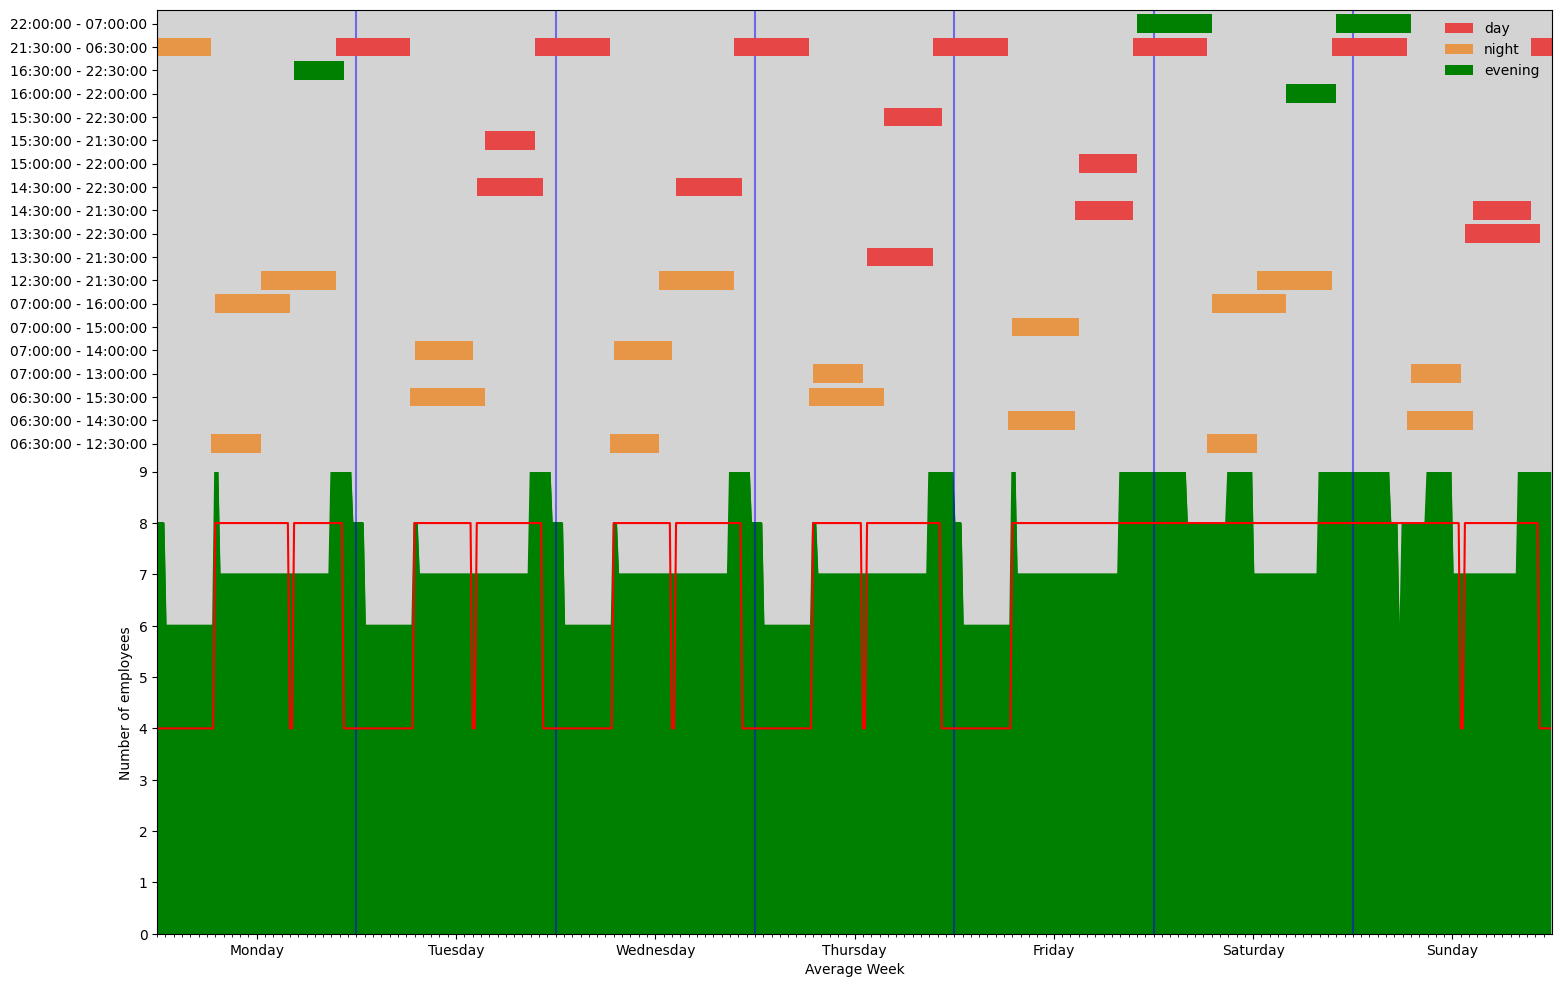

Total cost: 484682.0


In [19]:
earliest = 6
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 4
max_cap = 15
shift_lenghts = [6,7, 8,9]
overlap = 45

demand_weigth = 0.7

weights = {"1": (1, 1),
           "2": (1, 2),
           "3": (1, 3),
           "4": (1, 4),
           "5": (2, 1),
           "6": (3, 1)}
over_weight, under_weight = 1,1
# print("HardModel")
# results, final = run_hard(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap)
n_assigned, results, cost = run_soft(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap, demand_weigth, over_weight, under_weight)

Maximum shift length is respected: True


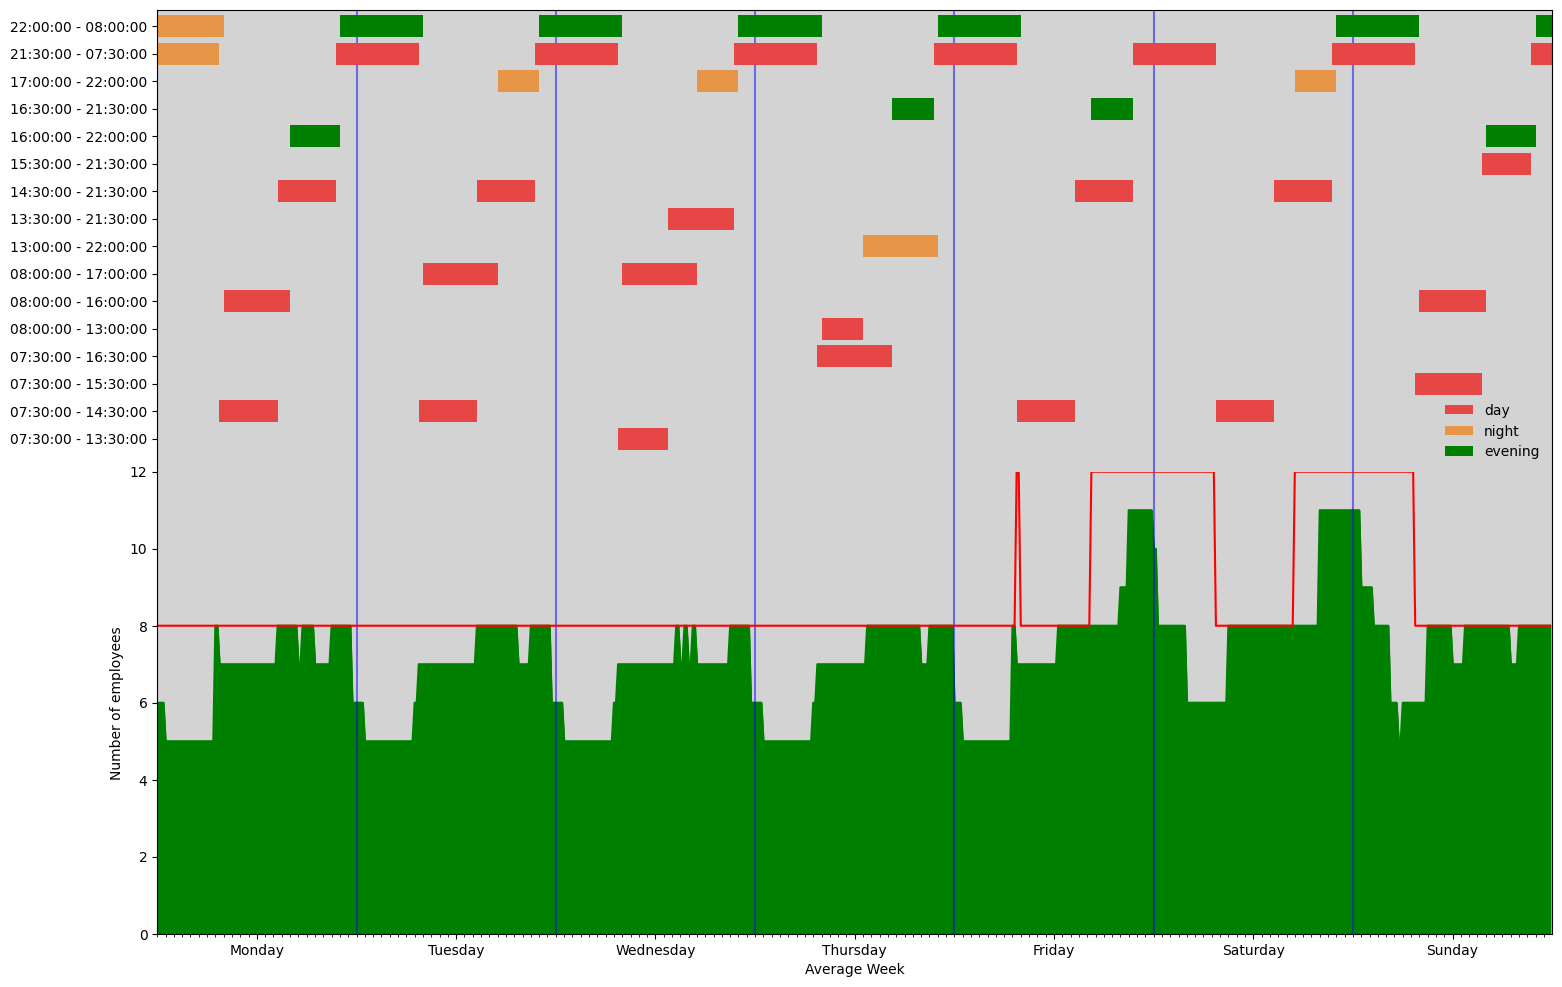

Average overstaffing: 1.5625
Maximum overcoverage: 7.0
Total cost: 628272.0


In [4]:
earliest = 7
latest = 22
minimum_night = 3
minimum_day = 4
teamsize = 4
max_cap = 15
shift_lenghts = [5,6,7, 8,9,10]
overlap = 45
demand_weigth = 0.85

weights = {"1": (1, 1),
           "2": (1, 2),
           "3": (1, 3),
           "4": (1, 4),
           "5": (2, 1),
           "6": (3, 1)}
# print("HardModel")
results, final = run_hard(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap)
# results_for_marthe = results[["Shift_name", "staff", "start_num", "end_num", "len"]].copy()
# results_for_marthe["end_num"] = results_for_marthe["end_num"].replace(672.00,0)
# results_for_marthe["start_num"] = results_for_marthe["start_num"].apply(lambda x: demand.index.tolist()[int(x)])
# results_for_marthe["end_num"] = results_for_marthe["end_num"].apply(lambda x: demand.index.tolist()[int(x)])
# results_for_marthe["len"] = results_for_marthe["len"].apply(lambda x : x//4)
# results_for_marthe
# overnight doesn't work properly 
# results_for_marthe.to_excel("ResultsForMarthe.xlsx", index = False, header = True)
# print("Soft Model")
# final = []
# for i, w in weights.items():
#     print(i)
#     over_weight = w[0]
#     under_weight = w[1]
#     n_assigned, results, cost = run_soft(earliest, latest, shift_lenghts, minimum_night, minimum_day, demand, timeframe, teamsize, max_cap, overlap, demand_weigth, over_weight, under_weight)
        
#     n_assigned["OverStaffing"] = (n_assigned["Assigned"] - n_assigned["Staffing_level"]).apply(lambda x : max(x, 0))
#     n_assigned["UnderStaffing"] = (n_assigned["Staffing_level"] - n_assigned["Assigned"]).apply(lambda x : max(x, 0))
#     overS = n_assigned["OverStaffing"].mean()
#     underS = n_assigned["UnderStaffing"].mean()

#     final.append((i, over_weight, under_weight, overS, underS, cost))

In [20]:
n_assigned["OverStaffing"] = (n_assigned["Assigned"] - n_assigned["Staffing_level"]).apply(lambda x : max(x, 0))
n_assigned["UnderStaffing"] = (n_assigned["Staffing_level"] - n_assigned["Assigned"]).apply(lambda x : max(x, 0))
overS = n_assigned["OverStaffing"].mean()
underS = n_assigned["UnderStaffing"].mean()

In [21]:
overS, underS

(0.48214285714285715, 0.9255952380952381)

In [10]:
pd.DataFrame.from_records(final, columns = ["Iteration", "OverstaffingWeight", "UnderstaffingWeight", "AvgOverstaffing", "AvgUnderstaffing", "Cost"])

,Iteration,OverstaffingWeight,UnderstaffingWeight,AvgOverstaffing,AvgUnderstaffing,Cost
0,1,1,1,0.34,0.61,"463,158.00"
1,2,1,2,0.60,0.40,"503,706.00"
2,3,1,3,0.97,0.18,"554,880.00"
3,4,1,4,1.23,0.07,"580,616.00"
4,5,2,1,0.31,0.76,"458,890.00"
5,6,3,1,0.15,1.21,"415,186.00"


In [4]:
# results_for_marthe.to_excel("ResultsForMarthe.xlsx", index = False, header = True)